In [ ]:
!apt-get update && apt-get install -y \
  ffmpeg \
  wget

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [498 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,064 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [993 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [966 kB]
Hit:12 http://archive.ubuntu.com/ubuntu jammy InReleas

In [ ]:
!pip install --no-cache-dir --upgrade pip && \
    pip install --no-cache-dir -r requirements.txt

In [ ]:
# IoU Threshold
iou_thresh = 0.6

# Objectness Threshold
obj_thresh = 0.6

In [ ]:
net_h, net_w = 416, 416

# 3 anchor boxes (width,height) pairs
anchors = [ [[116, 90], [156, 198], [373, 326]],
             [[30, 61], [62, 45], [59, 119]],
             [[10, 13], [16, 30], [33, 23]]]


NUM_CLASS = 80

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-09-13 16:26:36--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  19.5MB/s    in 13s     

2023-09-13 16:26:49 (18.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
from Model import YOLOv3
from tensorflow.keras.layers import Input
from WeightsReader import WeightReader

# create Yolo model
model = YOLOv3(Input(shape=(None, None, 3)), NUM_CLASS);
#model.summary()

# load the weights trained on COCO into the model
WeightReader("./yolov3.weights").load_weights(model)

In [ ]:
import cv2
from Utils import preprocess_image

# image_path   =  "./maradona_1.jpg"
image_path   =  "/content/dog.jpg"


# load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# normalize the image data and convert to 4D tensor
input = preprocess_image(image, net_h, net_w)

In [ ]:
output = model.predict(input)

1/1 [==============================] - 0s 25ms/step


In [ ]:
from Model import extract_features
import numpy as np

boxes = np.empty([1, 4])
scores = np.empty([1, ])
classes = np.empty([1, 80])

for i in range(len(output)):
    _, S = output[i].shape[:2]

    b, s, c = extract_features( output[i], anchors[i], S, N=3, num_classes=(80), net_wh=(416,416))

    boxes = np.concatenate((boxes, b), axis=0)
    scores = np.concatenate((scores, s), axis=0)
    classes = np.concatenate((classes, c), axis=0)

In [ ]:
import tensorflow as tf

selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(
                                        boxes, scores, len(boxes),
                                        iou_threshold=iou_thresh,
                                        score_threshold=obj_thresh ,
                                        )
# soft_nms_sigma=0.6

selected_boxes = tf.gather(boxes, selected_indices)
selected_classes = tf.gather(classes, selected_indices)

In [ ]:
from Utils import draw_boxes

draw_boxes(image, selected_boxes,selected_classes, selected_scores, image_w, image_h, net_w, net_h)
cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], (image).astype('uint8'))

ModuleNotFoundError: ignored

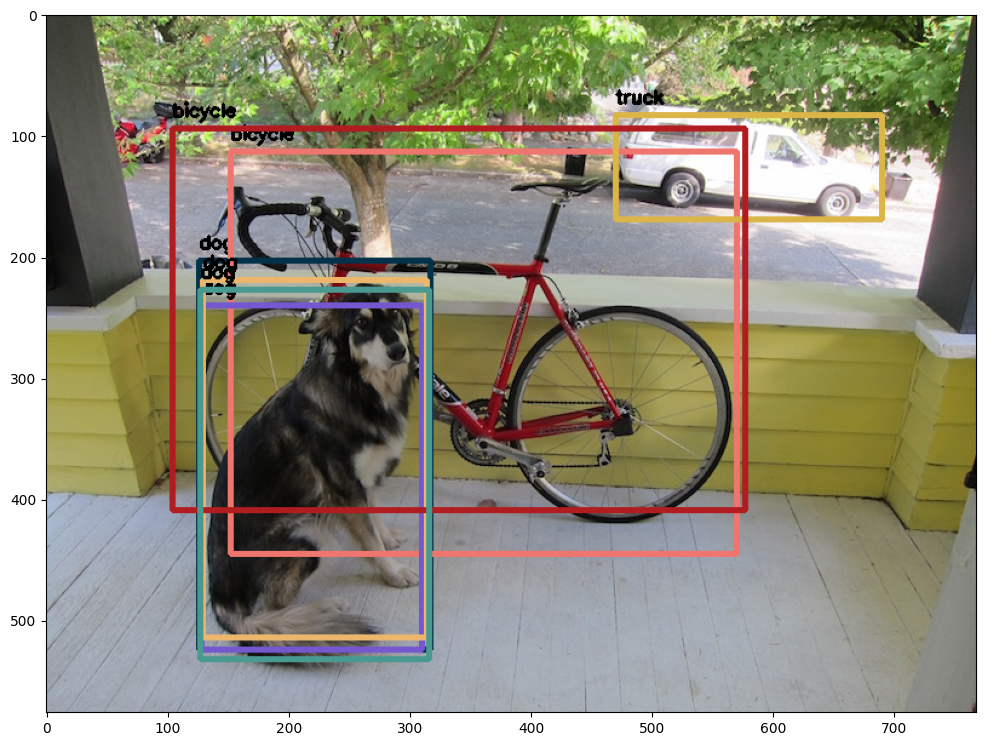

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
axis = fig.add_subplot()
plt.imshow(image)
plt.show()